In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from misc_functions import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import GradientBoostingRegressor
sns.set_palette('deep')

df = pd.read_csv('dataset/train.csv')
df = df[df['GrLivArea'] < 4000]
y_train = df['SalePrice'].values
df_test = pd.read_csv('dataset/test.csv')
test_split = 1

In [2]:
df_cum = pd.read_csv('df_cumulative.csv')

In [3]:
X_cum = df_cum.to_numpy()
standardScalerX = StandardScaler()
X_cum = standardScalerX.fit_transform(X_cum)

X_train = X_cum[:1456, :]
X_test = X_cum[1456:, :]
X_train.shape, X_test.shape

((1456, 324), (1459, 324))

##### Feature importance and getting rid of unnecessary ones

In [4]:
xg_reg = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0.75, reg_lambda=0.45,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)
xg_reg.fit(X_train,np.log(y_train))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, silent=True,
             subsample=0.6, tree_method=None, validate_parameters=False,
             verbosity=None)

In [5]:
x_ax = np.arange(len(xg_reg.feature_importances_))
# plt.figure(figsize=(90, 30))
# sns.barplot(x=x_ax, y=xg_reg.feature_importances_)

In [6]:
cols = []
for i,j in enumerate(xg_reg.feature_importances_):
    if j==0:
        cols.append(i)

In [7]:
X_cum_n = np.delete(X_cum, cols, 1)

In [8]:
X_cum_n.shape

(2915, 218)

In [9]:
X_train = X_cum_n[:1456, :]
X_test = X_cum_n[1456:, :]

In [10]:
if test_split:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

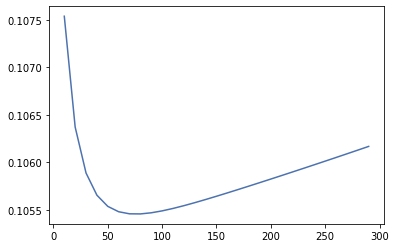

In [16]:
                 ###################### Parameter sweeping ##########################
val_list = []
score_list = []
for x in np.arange(10,300,10):
    model = Ridge(alpha=x)
    model.fit(X_train,np.log(y_train))
    y_pred = np.exp(model.predict(X_test))
    score_list.append(np.sqrt(metrics.mean_squared_error(np.log(y_test), np.log(y_pred))))
    val_list. append(x)
    
sns.lineplot(x=val_list, y=score_list, markers=True)
    

In [11]:
all_pred = np.array([])
n = 8

In [12]:
                             #### Gradient Boosting Regressor (0.1134)####
gbregressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=180)
gbregressor.fit(X_train, np.log(y_train))
y_pred = np.exp(gbregressor.predict(X_test))
all_pred = np.concatenate((all_pred, 0*y_pred))

In [13]:
                             #### Lasso LarsIC (0.119)####
lassolars = LassoLarsIC(criterion='aic')
lassolars.fit(X_train, np.log(y_train))
y_pred = np.exp(lassolars.predict(X_test))
all_pred = np.vstack((all_pred, 0*y_pred))

In [14]:
                             #### Random Forest (0.12401)####
rf_regressor = RandomForestRegressor(n_estimators = 325, random_state = 0)
rf_regressor.fit(X_train, np.log(y_train))
y_pred = np.exp(rf_regressor.predict(X_test))
all_pred = np.vstack((all_pred, 0*y_pred))

In [15]:
                             #### Bayesian Ridge (0.1054)####
bayesianridge = BayesianRidge(alpha_1=130, alpha_2=0.0017, lambda_1=0.00001, lambda_2=0.000001)
bayesianridge.fit(X_train, np.log(y_train))
y_pred = np.exp(bayesianridge.predict(X_test))
all_pred = np.vstack((all_pred, 0.17*y_pred))

In [16]:
                             #### ElasticNET (0.10032)####
elasticnet = ElasticNet(alpha=0.011, l1_ratio=0.5)
elasticnet.fit(X_train, np.log(y_train))
y_pred = np.exp(elasticnet.predict(X_test))
all_pred = np.vstack((all_pred, 0.21*y_pred))

In [17]:
                             #### Lasso (0.10026)####
lasso = Lasso(alpha=0.005)
lasso.fit(X_train, np.log(y_train))
y_pred = np.exp(lasso.predict(X_test))
all_pred = np.vstack((all_pred, 0.29*y_pred))

In [18]:
                             #### Ridge Regressor (0.1054)####
ridge = Ridge(alpha=75)
ridge.fit(X_train, np.log(y_train))
y_pred = np.exp(ridge.predict(X_test))
all_pred = np.vstack((all_pred, 0.14*y_pred))

In [19]:
                             #### XGBoost Regressor (0.10624)#####
xg_reg = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0.75, reg_lambda=0.45,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)
xg_reg.fit(X_train,np.log(y_train))
y_pred = np.exp(xg_reg.predict(X_test))
all_pred = np.vstack((all_pred, 0.19*y_pred))

In [20]:
y_pred = np.sum(all_pred, axis=0)

In [21]:
# df_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
# df_pred

In [22]:
if test_split:
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test), np.log(y_pred))))

In [23]:
if not test_split:
    id_array_test = df_test['Id'].values
    final_result = np.concatenate([id_array_test.reshape(-1,1), y_pred.reshape(-1,1)], axis=1)

    index_array = np.array([x for x in range(1459)])
    submission_df = pd.DataFrame(data=final_result, index=index_array, columns=['Id', 'SalePrice'])
    convert_dict = {'Id': int}

    submission_df = submission_df.astype(convert_dict)

    submission_df.to_csv('submission_get_dummies.csv',index=False)